## Purpose 
First model showed that using TF-IDF vectorizer and NMF decomposition led to the topics that made the most sense. 
Will re-iterate that pipeline only here, and expand analysis, for the us_pops data


In [1]:
import pickle
import numpy as np
import pandas as pd

import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.feature_extraction import text

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

In [2]:
file = open('../../Webscraper/us_pops_raw', 'rb')
us_pops_raw = pickle.load(file)
us_pops_raw = us_pops_raw.dropna().reset_index(drop=True)
us_pops = us_pops_raw['Lyrics']

# only keep alphanumeric, remove newlines, and make everything lowercase
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
rm_newline = lambda x: re.sub("\n", ' ',x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

us_pops_nopunc = us_pops.map(alphanumeric).map(rm_newline).map(punc_lower)

In [3]:
# lemmatize. do this by turning every line into a list of words, and concat back to full lyrics
us_pops_list = us_pops_nopunc.apply(lambda x: x.split(' '))

def lemmatize(list_of_words):
    lmt = WordNetLemmatizer()
    strg = ''
    for word in list_of_words:
        lem_word = lmt.lemmatize(word)
        if len(lem_word) > 2:
            strg += lem_word + ' '
    return strg

us_pops_clean = us_pops_list.apply(lemmatize)

In [4]:
stop_words_added = text.ENGLISH_STOP_WORDS.union(['huh','woo','whoa','hey','hold','really','gotta'])

tfidf =  TfidfVectorizer(
    stop_words = stop_words_added,
    max_df = 0.2,
    min_df = 0.0005
)
Y = tfidf.fit_transform(us_pops_clean)
doc_term_matrix = pd.DataFrame(Y.toarray(), columns=tfidf.get_feature_names())

In [5]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [6]:
# topic_word = pd.DataFrame(
#     nmf_model.components_.round(3),
#     columns = tfidf.get_feature_names()
#     )
# topic_word

In [7]:
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(doc_term_matrix)

display_topics(nmf_model, tfidf.get_feature_names(), 15)


Topic  0
believe, dream, stay, friend, gone, try, forever, better, true, long, home, wrong, fall, lie, inside

Topic  1
nigga, bitch, shit, fuck, ayy, money, gon, real, bad, lil, hoe, big, hit, fuckin, pussy

Topic  2
tonight, alright, waiting, tomorrow, fight, party, kiss, drink, tight, inside, dancing, touch, boo, end, leave

Topic  3
dance, body, shake, rock, everybody, party, stop, turn, floor, play, music, round, roll, club, beat

Topic  4
remember, used, memory, forget, gave, bring, fell, saying, wish, hurt, walk, bye, picture, sad, century


In [42]:
doc_topic_mat = pd.DataFrame(
    doc_topic.round(3),
    columns = ['"Dreams"','"Expletives"','"Passion"','"Dance"','"Reminiscence"']
)

# re-add Song/Artist
doc_topic_mat = doc_topic_mat.join(us_pops_raw[['Song','Artist']])

In [43]:
doc_topic_mat

,"""Dreams""","""Expletives""","""Passion""","""Dance""","""Reminiscence""",Song,Artist
0,0.061,0.000,0.000,0.011,0.000,Hold On,Wilson Phillips
1,0.063,0.000,0.006,0.007,0.000,It Must Have Been Love,Roxette
2,0.041,0.002,0.000,0.000,0.010,Nothing Compares 2 U,Sinéad O'Connor
3,0.019,0.011,0.002,0.017,0.001,Poison,Bell Biv DeVoe
4,0.000,0.000,0.000,0.080,0.001,Vogue,Madonna
...,...,...,...,...,...,...,...
2666,0.052,0.000,0.000,0.001,0.081,Eyes on You,Chase Rice
2667,0.039,0.000,0.006,0.056,0.000,All to Myself,Dan + Shay
2668,0.022,0.006,0.003,0.011,0.000,Boyfriend,Ariana Grande and Social House
2669,0.056,0.004,0.132,0.000,0.000,Walk Me Home,Pink


In [46]:
doc_topic_mat.sort_values('"Dance"',ascending=False).head(20)

,"""Dreams""","""Expletives""","""Passion""","""Dance""","""Reminiscence""",Song,Artist
97,0.000,0.000,0.000,0.286,0.000,Gonna Make You Sweat (Everybody Dance Now),C+C Music Factory
2340,0.000,0.000,0.000,0.281,0.000,Can't Stop the Feeling!,Justin Timberlake
756,0.000,0.000,0.002,0.278,0.000,Everybody (Backstreet's Back),Backstreet Boys
130,0.000,0.000,0.000,0.276,0.007,Here We Go,C+C Music Factory
1374,0.000,0.000,0.000,0.273,0.000,"1, 2 Step",Ciara featuring Missy Elliott
1217,0.009,0.000,0.000,0.267,0.000,Rock Your Body,Justin Timberlake
230,0.000,0.000,0.000,0.261,0.008,Move This,Technotronic featuring Ya Kid K
1000,0.000,0.000,0.000,0.258,0.000,Dance with Me,Debelah Morgan
1895,0.000,0.000,0.090,0.255,0.000,Party Rock Anthem,LMFAO featuring Lauren Bennett and GoonRock
2226,0.000,0.000,0.003,0.244,0.000,Do What U Want,Lady Gaga featuring R. Kelly


In [47]:
Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(doc_topic_mat.iloc[:,:5])
    Sum_of_squared_distances.append(km.inertia_)

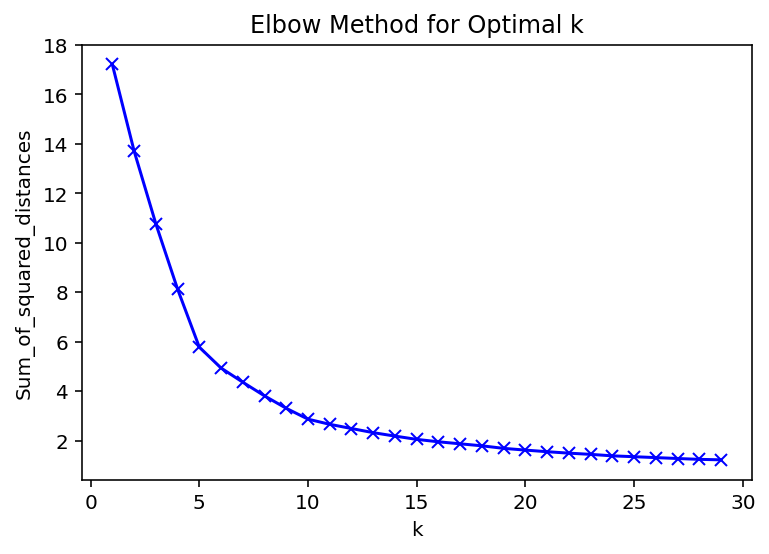

In [48]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method for Optimal k')
plt.show()

### Try 5, 10, or 15

In [49]:
# Imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format='retina'

# Load in the data
df = doc_topic_mat.iloc[:,:5]

# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(df)

# Create a PCA instance: pca
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X_std)

x_pca = pca.transform(X_std)

In [50]:
modelkmeans = KMeans(n_clusters = 15, random_state = 42)
hello = modelkmeans.fit(doc_topic_mat.iloc[:,:5])

In [51]:
labels = modelkmeans.fit_predict(doc_topic_mat.iloc[:,:5])

In [52]:
doc_topic_mat['cluster'] = labels

In [53]:
doc_topic_mat

,"""Dreams""","""Expletives""","""Passion""","""Dance""","""Reminiscence""",Song,Artist,cluster
0,0.061,0.000,0.000,0.011,0.000,Hold On,Wilson Phillips,9
1,0.063,0.000,0.006,0.007,0.000,It Must Have Been Love,Roxette,9
2,0.041,0.002,0.000,0.000,0.010,Nothing Compares 2 U,Sinéad O'Connor,14
3,0.019,0.011,0.002,0.017,0.001,Poison,Bell Biv DeVoe,1
4,0.000,0.000,0.000,0.080,0.001,Vogue,Madonna,5
...,...,...,...,...,...,...,...,...
2666,0.052,0.000,0.000,0.001,0.081,Eyes on You,Chase Rice,11
2667,0.039,0.000,0.006,0.056,0.000,All to Myself,Dan + Shay,12
2668,0.022,0.006,0.003,0.011,0.000,Boyfriend,Ariana Grande and Social House,1
2669,0.056,0.004,0.132,0.000,0.000,Walk Me Home,Pink,0


In [54]:
# doc_topic_mat[doc_topic_mat['cluster'] == 0][doc_topic_mat['Artist'].str.contains('Eminem')].tail(60)

In [55]:
hip = doc_topic_mat[doc_topic_mat['cluster'] == 2]
hip.iloc[int(len(hip)//3.3):int(len(hip)//1.43)]

,"""Dreams""","""Expletives""","""Passion""","""Dance""","""Reminiscence""",Song,Artist,cluster
1440,0.000,0.226,0.000,0.000,0.052,U Don't Know Me,T.I.,2
1526,0.008,0.187,0.004,0.049,0.000,Touch It,Busta Rhymes,2
1912,0.004,0.226,0.000,0.000,0.000,Look at Me Now,Chris Brown featuring Lil Wayne and Busta Rhymes,2
1930,0.013,0.262,0.002,0.000,0.001,6 Foot 7 Foot,Lil Wayne featuring Cory Gunz,2
1935,0.023,0.199,0.003,0.013,0.003,I'm on One,"DJ Khaled featuring Drake, Rick Ross and Lil W...",2
1977,0.013,0.191,0.000,0.000,0.002,She Will,Lil Wayne featuring Drake,2
1999,0.000,0.253,0.000,0.000,0.000,The Motto,Drake featuring Lil Wayne,2
2104,0.000,0.237,0.000,0.000,0.000,Love Me,Lil Wayne featuring Drake and Future,2
2216,0.000,0.247,0.000,0.000,0.000,Lifestyle,Rich Gang featuring Young Thug and Rich Homie ...,2
2229,0.009,0.227,0.000,0.000,0.000,No Mediocre,T.I. featuring Iggy Azalea,2


In [56]:
hip = doc_topic_mat[doc_topic_mat['cluster'] == 8]
hip.iloc[int(len(hip)//2.2):int(len(hip)//1.8)]

,"""Dreams""","""Expletives""","""Passion""","""Dance""","""Reminiscence""",Song,Artist,cluster
1518,0.026,0.058,0.001,0.040,0.002,Bossy,Kelis featuring Too Short,8
1562,0.000,0.061,0.000,0.055,0.000,This Is Why I'm Hot,Mims,8
1572,0.032,0.070,0.015,0.035,0.000,We Fly High,Jim Jones,8
1587,0.026,0.051,0.000,0.000,0.000,Make It Rain,Fat Joe featuring Lil Wayne,8
1594,0.053,0.051,0.000,0.025,0.001,Shortie Like Mine,Bow Wow featuring Chris Brown and Johntá Austin,8
1618,0.006,0.037,0.000,0.022,0.001,Go Getta,Young Jeezy featuring R. Kelly,8
1635,0.003,0.095,0.002,0.053,0.000,That's That,Snoop Dogg featuring R. Kelly,8
1645,0.000,0.062,0.013,0.070,0.000,Sexy Can I,Ray J featuring Yung Berg,8
1666,0.011,0.059,0.000,0.026,0.000,Paper Planes,M.I.A.,8
1670,0.007,0.092,0.020,0.041,0.001,Got Money,Lil Wayne featuring T-Pain,8


In [57]:
doc_topic_mat.groupby(['cluster']).mean()*100

,"""Dreams""","""Expletives""","""Passion""","""Dance""","""Reminiscence"""
cluster,,,,,
0,3.678313,0.695181,8.997590,1.374699,0.477108
1,1.685193,0.828755,0.294421,1.157511,0.227897
2,0.333333,22.239583,0.141667,0.445833,0.216667
3,0.376923,0.046154,0.476923,0.192308,47.600000
4,1.173874,12.982883,0.254955,2.004505,0.130631
5,1.165942,1.484058,1.253623,10.615942,0.234058
6,0.248837,0.641860,0.609302,20.406977,0.281395
7,0.645455,0.890909,36.381818,2.072727,0.654545
8,1.890722,6.568041,0.346392,2.030412,0.324742


In [58]:
doc_topic_mat.groupby(['cluster']).count().iloc[:,0]

cluster
0      83
1     466
2      48
3      13
4     111
5     138
6      43
7      11
8     194
9     406
10     31
11     69
12    340
13     19
14    699
Name: "Dreams", dtype: int64

In [59]:
nineties = doc_topic_mat.iloc[:866].groupby(['cluster']).count().iloc[:,0]
tens = doc_topic_mat.iloc[1812:].groupby(['cluster']).count().iloc[:,0]
tens/nineties

cluster
0     1.260870
1     1.258503
2     5.333333
3     0.285714
4     4.071429
5     1.194444
6     1.090909
7     1.666667
8     2.428571
9     0.435028
10    1.444444
11    0.818182
12    0.918919
13    2.500000
14    0.724138
Name: "Dreams", dtype: float64

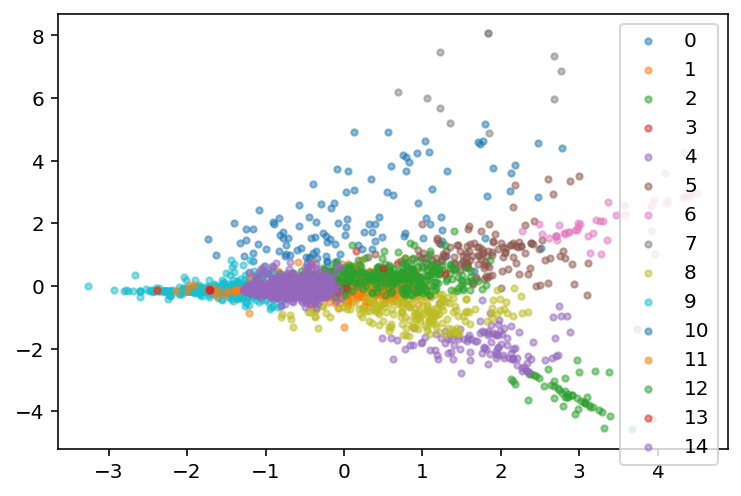

In [60]:
fig, ax = plt.subplots()
for g in np.unique(labels):
    ix = np.where(labels == g)
    ax.scatter(x_pca[:,0][ix], x_pca[:,1][ix], label = g, s = 10 ,alpha = 0.5)
ax.legend()
plt.show()